In [29]:
%load_ext autoreload
%autoreload 2
import VAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle

PICKLE_DIR = '/home/solnik/floor_plans/Final Projects/pickles'

def save(obj, name, pickle_dir=PICKLE_DIR):
    print(f"SAVING {pickle_dir}/{name} ")
    with open(f'{pickle_dir}/{name}', "wb") as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load(name, pickle_dir=PICKLE_DIR):
    with open(f'{pickle_dir}/{name}', "rb") as handle:
        return pickle.load(handle)

In [3]:
import pandas as pd

In [4]:
geometries = pd.read_csv('data/swiss-dwellings/geometries.csv')

In [5]:
apartment_ids = list(set(geometries[geometries['unit_usage'] == 'RESIDENTIAL']['apartment_id']))

In [6]:
polygon_lengths = list(sorted(geometries['geometry'].apply(lambda x: len(x[len('POLYGON '):].split(',')))))

In [7]:
def get_geometries(apartment_id):
    return geometries[geometries['apartment_id'] == apartment_id]

In [8]:
import random
import functools

random.seed(10)
@functools.lru_cache
def get_entity_type_color(entity_type: str):
    return f"#{randrange(0, 0xffffff):0>6x}"

In [9]:
from shapely.geometry import LineString
from wktplot import WKTPlot
from random import randrange
from bokeh.io import export_png

def plot_aparment_with_color_getter(apartment_id: str, subtypes, get_color, save_dir):
    plot = WKTPlot(title=f"Apartment {apartment_id}")
    for i, row in get_geometries(apartment_id).iterrows():
        entity_subtype = row['entity_subtype']
        if entity_subtype in subtypes:
            plot.add_shape(row['geometry'], fill_color=get_entity_type_color(entity_subtype))
    export_png(plot.figure, filename=f'apt_{apartment_id}.png')

def plot_apartment(apartment_id: str, subtypes):
    plot = WKTPlot(title=f"Apartment", save_dir='/home/solnik/floor_plans/Final Projects/plans')
    for i, row in get_geometries(apartment_id).iterrows():
        entity_subtype = row['entity_subtype']
        if entity_subtype in subtypes:
            plot.add_shape(row['geometry'], fill_color=get_entity_type_color(entity_subtype))
    export_png(plot.figure, filename=f'/home/solnik/floor_plans/Final Projects/plans/apt_{apartment_id}.png')

In [10]:
for apartment_id in apartment_ids[:10]:
    print(apartment_id)
    plot_apartment(apartment_id, list(set(get_geometries(apartment_id)['entity_subtype'])))

8d951e4ad355037cd22d118e148c81d7
15dd05bd29db2ddbce9914363a96715d
d3d4d4eee3949deeba9bb236dce03931
f65c6b4cc2e7dae1366698e219a7b3ea
66f0a3b7c6263562eec8162868bb1e76
9466896cc5fd671aabfff3a73e4d11f6
7046219ec52e2cf853dda18f4872d941
7d7c35c90ccf88dc1339d45c25973b11
9603e931bf74b97e4f4c7830a626f451
a3d811cf79f3039c634327ddee3122ea


In [10]:
import numpy as np

entity_types_unique, mask = np.unique(geometries['entity_type'], return_inverse=True)

In [11]:
geometries['entity_type_unique'] = mask

In [16]:
entity_types_unique

array(['area', 'feature', 'opening', 'separator'], dtype=object)

In [17]:
geometries['entity_subtype'].unique()

array(['LOBBY', 'STOREROOM', 'BALCONY', 'SANITARY_ROOMS', 'CLOAKROOM',
       'SPORTS_ROOMS', 'COMMON_KITCHEN', 'STAIRS', 'BATHTUB', 'SINK',
       'TOILET', 'KITCHEN', 'WALL', 'RAILING', 'WINDOW', 'DOOR',
       'ENTRANCE_DOOR', 'STAIRCASE', 'ELEVATOR', 'SHAFT', 'ROOM',
       'CORRIDOR', 'BATHROOM', 'LIVING_ROOM', 'SHOWER', 'COLUMN',
       'LIVING_DINING', 'VOID', 'NOT_DEFINED', 'OFFICE', 'DINING',
       'OUTDOOR_VOID', 'KITCHEN_DINING', 'BEDROOM', 'LOGGIA',
       'BASEMENT_COMPARTMENT', 'WASH_AND_DRY_ROOM', 'HEATING', 'GARAGE',
       'PRAM', 'LIGHTWELL', 'WINTERGARTEN', 'BUILT_IN_FURNITURE',
       'TECHNICAL_AREA', 'BIKE_STORAGE', 'WASHING_MACHINE', 'RAMP',
       'TERRACE', 'BASEMENT', 'SALESROOM', 'OIL_TANK', 'FOYER',
       'OFFICE_SPACE', 'OFFICE_TECH_ROOM', 'CORRIDORS_AND_HALLS',
       'WAREHOUSE', 'CARPARK', 'MEETING_ROOM', 'OPEN_PLAN_OFFICE',
       'BREAK_ROOM', 'ARCHIVE', 'WAITING_ROOM', 'CANTEEN', 'MEDICAL_ROOM',
       'PHYSIO_AND_REHABILITATION', 'RADATION_THERAPY'

In [18]:
import shapely
import matplotlib.pyplot as plt
import rasterio.features
from shapely.geometry import Polygon

X, Y = 64, 64
#img = rasterio.features.rasterize([(geom, i) for i, geom in enumerate(geometries_apt10['geometry_polygons'])], out_shape=(X, Y))
#plt.imshow(img)

def geometry_rows_to_rasterized(rows, X=X, Y=Y):
    polygons = rows['geometry'].apply(lambda geom: shapely.wkt.loads(geom))
    xs = [x
    for polygon in polygons
    for x, y in polygon.exterior.coords[:]]

    ys = [y
    for polygon in polygons
    for x, y in polygon.exterior.coords[:]]
    min_x = min(xs)
    max_x = max(xs)
    min_y = min(ys)
    max_y = max(ys)

    def transform_polygon(polygon):
        coords = polygon.exterior.coords[:]
        return Polygon([(X * (x - min_x) / (max_x - min_x), Y * (y - min_y) /(max_y - min_y)) for x, y in coords])
    
    entity_subtypes = rows['entity_subtype']
    has_balcony = 'BALCONY' in entity_subtypes

    num_bathrooms = (entity_subtypes == 'BATHROOM').sum()
    num_bedrooms = (entity_subtypes == 'BEDROOM').sum()

    return pd.Series(
        {
            'apartment_id': rows['apartment_id'].iloc[0], 
            'raster': rasterio.features.rasterize([(transform_polygon(polygon), i + 1) for i, polygon in zip(rows['entity_type_unique'], polygons)], out_shape=(X, Y)),
            'balcony': has_balcony,
            'bath': num_bathrooms,
            'bed': num_bedrooms,
        })     

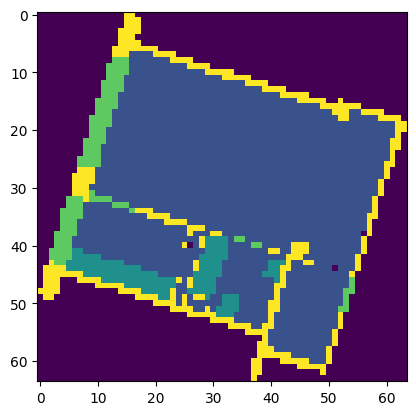

In [19]:
apt_1 = get_geometries(apartment_ids[0])
plt.imshow(geometry_rows_to_rasterized(apt_1)['raster'])

In [16]:
geometries = geometries[geometries['unit_usage'] == 'RESIDENTIAL']
geometries = geometries[['apartment_id', 'entity_type_unique', 'geometry', 'entity_subtype']]

geometries_rasterized = geometries.groupby('apartment_id').apply(geometry_rows_to_rasterized)

In [17]:
geometries_rasterized_saved = geometries_rasterized.copy()

In [18]:
geometries_rasterized = geometries_rasterized[geometries_rasterized['bath'] < 9]
geometries_rasterized = geometries_rasterized[geometries_rasterized['bed'] < 9]

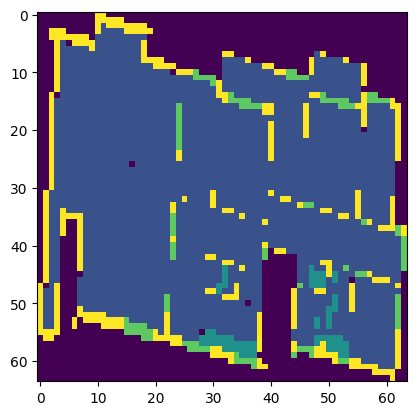

In [19]:
import matplotlib.pyplot as plt
import rasterio.features

plt.imshow(geometries_rasterized[geometries_rasterized['bath'] == 4].iloc[0]['raster'])

In [20]:
#save(geometries_rasterized, 'geometries_rasterized_1')
geometries_rasterized = load('geometries_rasterized_1')

In [21]:
numpy_arr_with_labels = geometries_rasterized.to_numpy()
numpy_arr_geometries = numpy_arr_with_labels[:, 1]

numpy_arr_baths = numpy_arr_with_labels[:, 3]
numpy_arr_beds = numpy_arr_with_labels[:, 4]

In [22]:
#save(numpy_arr_geometries, 'numpy_arr_geometries')
#save(numpy_arr_beds, 'numpy_arr_beds')
#save(numpy_arr_baths, 'numpy_arr_baths')
numpy_arr_geometries = load('numpy_arr_geometries')
numpy_arr_beds = load('numpy_arr_beds')
numpy_arr_baths = load('numpy_arr_baths')

In [26]:
#save(entity_types_unique, 'entity_types_unique_1')
entity_types_unique = load('entity_types_unique_1')

In [27]:
import numpy as np

In [28]:
def stack_and_int(arr):
    arr = np.stack(arr)
    arr.shape
    return arr.astype(np.int)

In [32]:
numpy_arr_geometries = stack_and_int(numpy_arr_geometries)
numpy_arr_beds = stack_and_int(numpy_arr_beds)
numpy_arr_baths = stack_and_int(numpy_arr_baths)

/tmp/ipykernel_9702/4126886576.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return arr.astype(np.int)


In [33]:
import torch

geometries_tensor = torch.from_numpy(numpy_arr_geometries)
beds_tensor = torch.from_numpy(numpy_arr_beds)
baths_tensor = torch.from_numpy(numpy_arr_baths)

In [34]:
X = 64
Y = 64

In [35]:
import os

import numpy as np
import torch
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torchvision.transforms as transforms

import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch import Tensor
from math import prod
from typing import Tuple

NUM_PIXELS = X * Y

In [36]:
tensors = [geometries_tensor, beds_tensor, baths_tensor]

In [37]:
geometries_tensor_reshaped = geometries_tensor.resize(geometries_tensor.shape[0], prod(geometries_tensor.shape[1:]))

/home/solnik/floor_plans/env/lib/python3.10/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [38]:
tensors = [(geometries_tensor_reshaped / 4).type(torch.float), beds_tensor.type(torch.float), baths_tensor.type(torch.float)]

In [42]:
tensors = tensors[0]

In [45]:
pyro.clear_param_store()
vae, train_losses, test_losses = VAE.make_vae(tensors, 64, 64 * 4, epochs=101, lr=1e-3)

[epoch 000]  average training loss: 1979.9032
[epoch 000] average test loss: 1920.4197
[epoch 001]  average training loss: 1891.7314
[epoch 002]  average training loss: 1852.4138
[epoch 003]  average training loss: 1824.9451
[epoch 004]  average training loss: 1798.6965
[epoch 005]  average training loss: 1779.6054
[epoch 006]  average training loss: 1765.3326
[epoch 007]  average training loss: 1757.4472
[epoch 008]  average training loss: 1750.4607
[epoch 009]  average training loss: 1744.6956
[epoch 010]  average training loss: 1739.6033
[epoch 010] average test loss: 1746.3091
[epoch 011]  average training loss: 1735.4299
[epoch 012]  average training loss: 1731.1408
[epoch 013]  average training loss: 1727.1527
[epoch 014]  average training loss: 1723.8305
[epoch 015]  average training loss: 1720.7753
[epoch 016]  average training loss: 1716.9242
[epoch 017]  average training loss: 1713.6372
[epoch 018]  average training loss: 1710.5809
[epoch 019]  average training loss: 1707.383

In [106]:
def reconstruct_img(vae, xs, ind, categorical=False):
    def get_cuda(i):
        return xs[ind: ind + 1].cuda()
    # encode image x
    # beds_loc, beds_scale = vae.encoder_beds(geom)
    # bath_loc, bath_scale = vae.encoder_beds(geom)
    # beds = dist.Normal(beds_loc, beds_scale).sample()
    # baths = dist.Normal(bath_loc, bath_scale).sample()
    
    z_loc, z_scale = vae.encode(get_cuda(ind))
    z = dist.Normal(z_loc, z_scale).sample()
    # decode the image (note we don't sample in image space)
    loc_img = vae.decode(z)
    return loc_img

def from_cuda_and_resize(t, categorical=False, wall_thresh=None):
    numpy_arr = t.cpu().detach().numpy()
    if categorical:
        numpy_arr = numpy_arr.reshape(X * Y, 5)
        if wall_thresh:
            numpy_arr[:, 4][numpy_arr[:, 4] > wall_thresh] =4
        numpy_arr = np.argmax(numpy_arr, axis=1)
    
    res = numpy_arr.reshape(X, Y)
    return res

def get_pred_and_real(vae, ts, ind, categorical=False):
    t = ts[ind:ind + 1, :].cuda()
    img = reconstruct_img(vae, ts, ind)
    return from_cuda_and_resize(img, categorical=categorical), from_cuda_and_resize(t)

In [83]:
test_losses_pd = pd.Series([np.nan] * 101)
for i in range(10):
    test_losses_pd[10 * i] = test_losses[i]
    
test_losses_pd = test_losses_pd.interpolate()

<AxesSubplot: title={'center': 'ELBO Per Epoch for Cotinuous Bernoulli Simple Model'}>

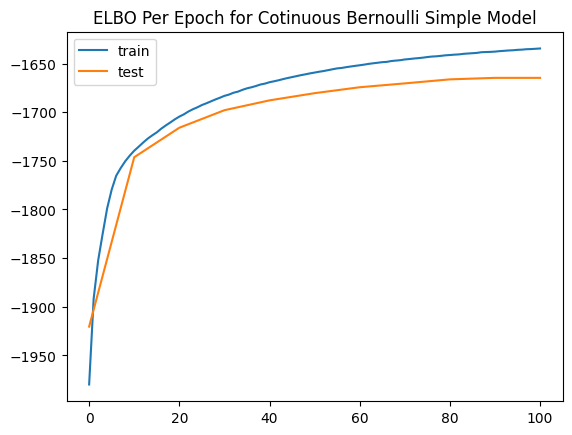

In [90]:
pd.DataFrame({'train': train_losses, 'test': test_losses_pd}).plot(title='ELBO Per Epoch for Cotinuous Bernoulli Simple Model')

In [ ]:
import random

random.sample(range(len(tensors)), 6)

In [ ]:
indicies = [9089, 39530, 23270, 25008, 27607, 18587]

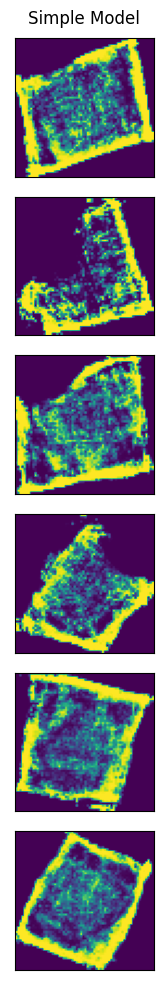

In [214]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(indicies), 1, sharex=True, sharey=True, figsize=[5, 10])
f.suptitle('Simple Model')
imgs = []
for i, ind in enumerate(indicies):
    pred, real = get_pred_and_real(vae, tensors.type(torch.float).cuda(), ind)
    imgs.append(pred)
    axarr[i].imshow(pred)
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [190]:
save(imgs, 'Predictions Simple Continuous Bernoulli')

SAVING /home/solnik/floor_plans/Final Projects/pickles/Predictions Simple Continuous Bernoulli 


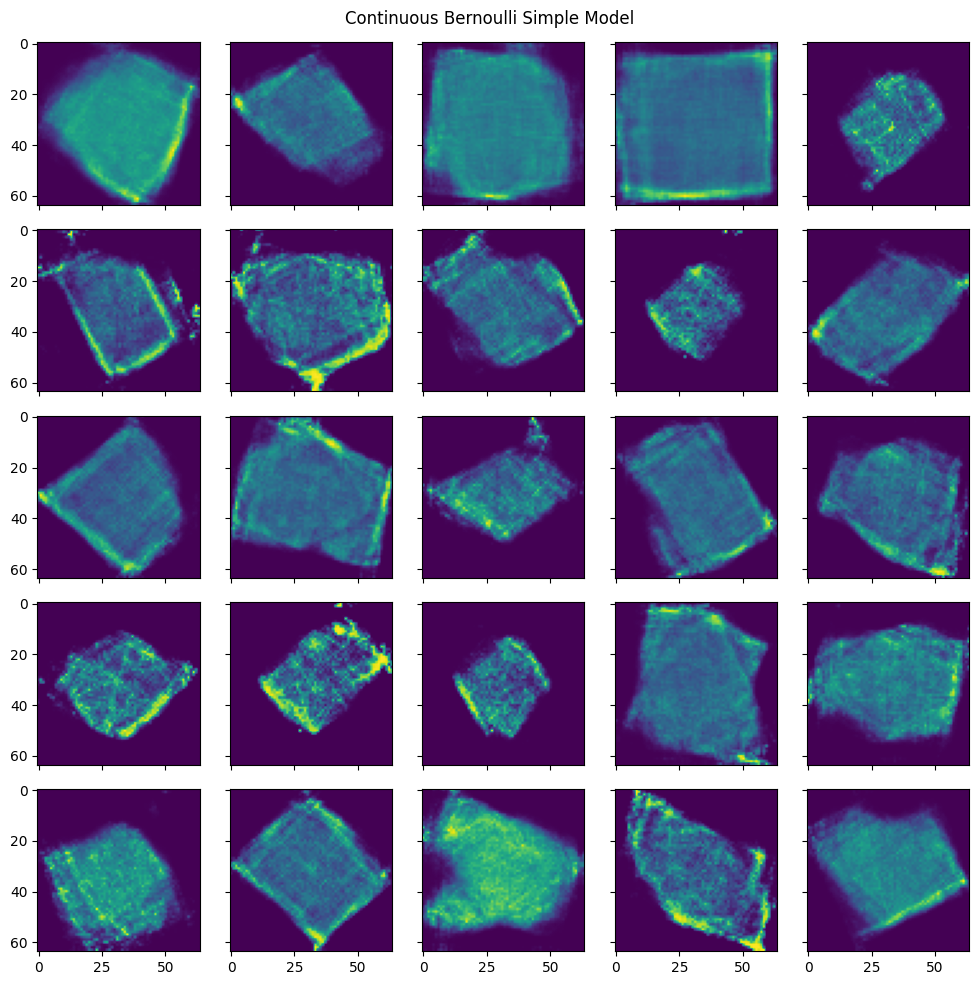

In [216]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5, 5, sharex=True, sharey=True, figsize=[10, 10])
f.suptitle('Continuous Bernoulli Simple Model')
for beds in range(1, 6):
    for baths in range(1, 6):
        z_loc = tensors[0].new_zeros(torch.Size((1, 64))).type(torch.float)
        z_scale = tensors[0].new_ones(torch.Size((1, 64))).type(torch.float)
        z = dist.Normal(z_loc, z_scale)()
        decoded = vae.decode(z.cuda())
        numpy_arr = from_cuda_and_resize(decoded)
        axarr[beds -1][baths - 1].imshow(numpy_arr)
plt.tight_layout()

In [135]:
tensors = (tensors * 4).type(torch.int)

In [137]:
pyro.clear_param_store()
vae, train_losses, test_losses = VAE.make_vae(tensors, 64, 64 * 4, epochs=101, lr=1e-3, vae_class=VAE.AmortizedVAECategorical)

/home/solnik/floor_plans/env/lib/python3.10/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


[epoch 000]  average training loss: 3213.4857
[epoch 000] average test loss: 2784.9971
[epoch 001]  average training loss: 2507.3980
[epoch 002]  average training loss: 2166.7498
[epoch 003]  average training loss: 2004.7276
[epoch 004]  average training loss: 1895.2431
[epoch 005]  average training loss: 1817.8388
[epoch 006]  average training loss: 1757.9139
[epoch 007]  average training loss: 1706.1823
[epoch 008]  average training loss: 1664.6722
[epoch 009]  average training loss: 1627.2896
[epoch 010]  average training loss: 1595.8156
[epoch 010] average test loss: 1611.2803
[epoch 011]  average training loss: 1566.0083
[epoch 012]  average training loss: 1543.2072
[epoch 013]  average training loss: 1519.7730
[epoch 014]  average training loss: 1499.3275
[epoch 015]  average training loss: 1479.4737
[epoch 016]  average training loss: 1461.9660
[epoch 017]  average training loss: 1446.6945
[epoch 018]  average training loss: 1431.7433
[epoch 019]  average training loss: 1417.583

In [138]:
test_losses_pd = pd.Series([np.nan] * 101)
for i in range(10):
    test_losses_pd[10 * i] = test_losses[i]
    
test_losses_pd = test_losses_pd.interpolate()

<AxesSubplot: title={'center': 'ELBO Per Epoch for Categorical Simple Model'}>

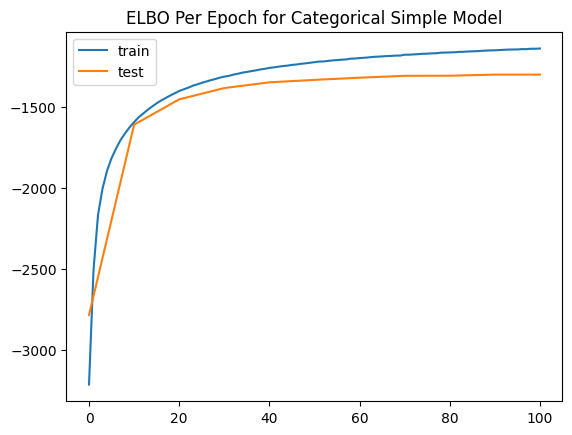

In [139]:
pd.DataFrame({'train': train_losses, 'test': test_losses_pd}).plot(title='ELBO Per Epoch for Categorical Simple Model')

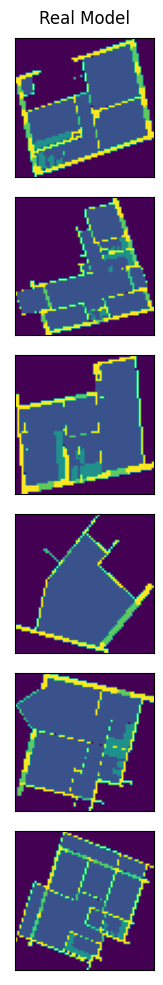

In [193]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(indicies), 1, sharex=True, sharey=True, figsize=[5, 10])
f.suptitle('Real Model')
imgs = []
for i, ind in enumerate(indicies):
    pred, real = get_pred_and_real(vae, tensors.cuda(), ind, categorical=True)
    axarr[i].imshow(real)
    imgs.append(real)
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [194]:
save(imgs, 'Real')

SAVING /home/solnik/floor_plans/Final Projects/pickles/Real 


/home/solnik/floor_plans/env/lib/python3.10/site-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


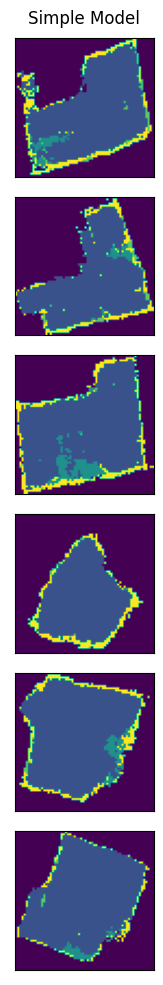

In [186]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(indicies), 1, sharex=True, sharey=True, figsize=[5, 10])
f.suptitle('Simple Model')
imgs = []
for i, ind in enumerate(indicies):
    pred, real = get_pred_and_real(vae, tensors.cuda(), ind, categorical=True)
    axarr[i].imshow(pred)
    imgs.append(pred)
    axarr[i].get_xaxis().set_visible(False)
    axarr[i].get_yaxis().set_visible(False)
plt.tight_layout()

In [187]:
save(imgs, 'Predictions Simple Categorical')

SAVING /home/solnik/floor_plans/Final Projects/pickles/Predictions Simple Categorical 


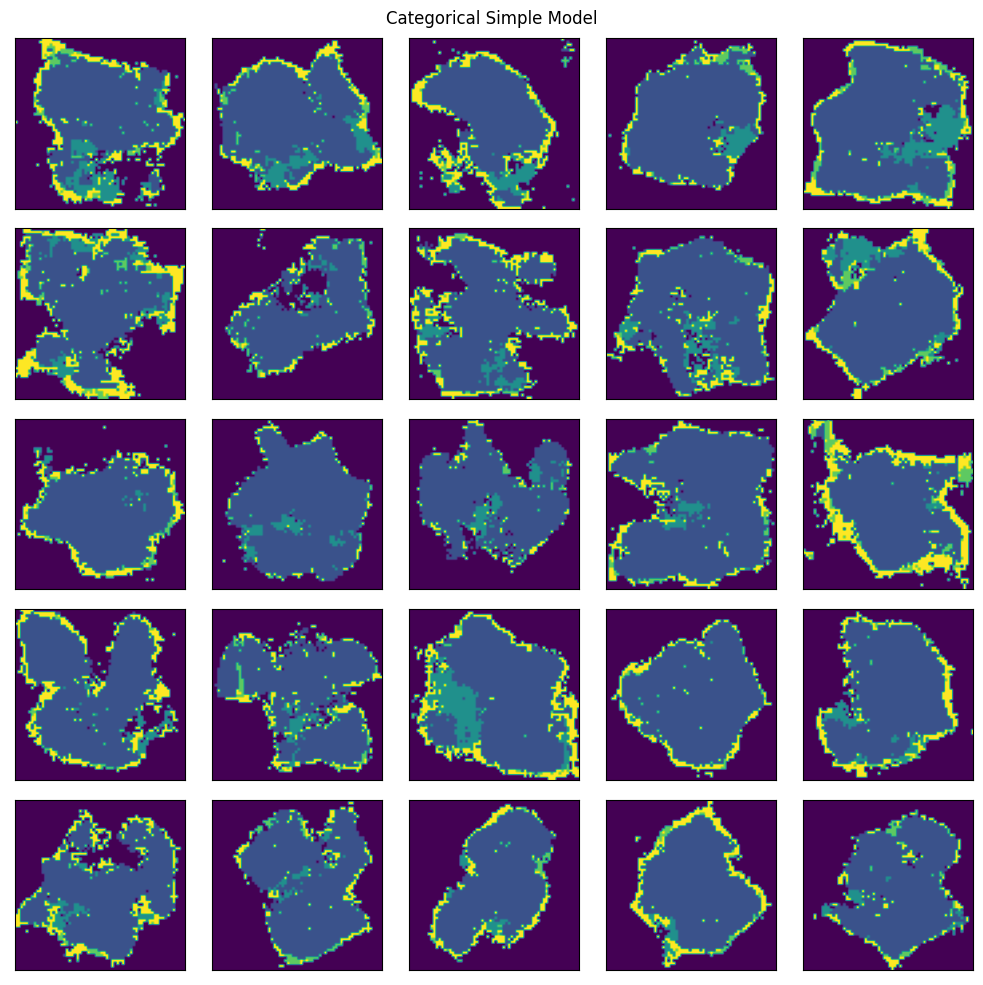

In [211]:
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(5, 5, sharex=True, sharey=True, figsize=[10, 10])
f.suptitle('Categorical Simple Model')
for beds in range(1, 6):
    for baths in range(1, 6):
        z_loc = tensors[0].new_zeros(torch.Size((1, 64))).type(torch.float)
        z_scale = tensors[0].new_ones(torch.Size((1, 64))).type(torch.float)
        z = dist.Normal(z_loc, z_scale)()
        decoded = vae.decode(z.cuda())
        numpy_arr = from_cuda_and_resize(decoded, categorical=True)
        ax = axarr[beds - 1][baths -1 ]
        ax.imshow(numpy_arr)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.tight_layout()

In [157]:
train_losses_cat = train_losses
test_losses_pd_cat = test_losses_pd

In [188]:
vae, train_losses, test_losses = VAE.load_model('20221216-165932_AmortizedVAE_42371_64_256')

In [192]:
vae, train_losses, test_losses = VAE.load_model('20221216-173913_AmortizedVAECategorical_42371_64_256')

In [162]:
test_losses_pd = pd.Series([np.nan] * 101)
for i in range(10):
    test_losses_pd[10 * i] = test_losses[i]
    
test_losses_pd = test_losses_pd.interpolate()

In [202]:
pyro.clear_param_store()
vae, train_losses, test_losses = VAE.make_vae(tensors, 64 * 2, 64 * 5, epochs=101, lr=1e-3, vae_class=VAE.AmortizedVAECategorical)

[epoch 000]  average training loss: 2842.7808
[epoch 000] average test loss: 2420.8916
[epoch 001]  average training loss: 2248.3785
[epoch 002]  average training loss: 2039.7711
[epoch 003]  average training loss: 1957.9426
[epoch 004]  average training loss: 1905.9645
[epoch 005]  average training loss: 1858.1882
[epoch 006]  average training loss: 1811.8650
[epoch 007]  average training loss: 1772.2871
[epoch 008]  average training loss: 1735.2185
[epoch 009]  average training loss: 1704.6098
[epoch 010]  average training loss: 1676.9925
[epoch 010] average test loss: 1679.2639
[epoch 011]  average training loss: 1650.7982
[epoch 012]  average training loss: 1628.3382
[epoch 013]  average training loss: 1603.5900
[epoch 014]  average training loss: 1587.6197
[epoch 015]  average training loss: 1568.9556
[epoch 016]  average training loss: 1553.7035
[epoch 017]  average training loss: 1537.5415
[epoch 018]  average training loss: 1522.6969
[epoch 019]  average training loss: 1510.167

<AxesSubplot: title={'center': 'ELBO Per Epoch for Simple Model'}>

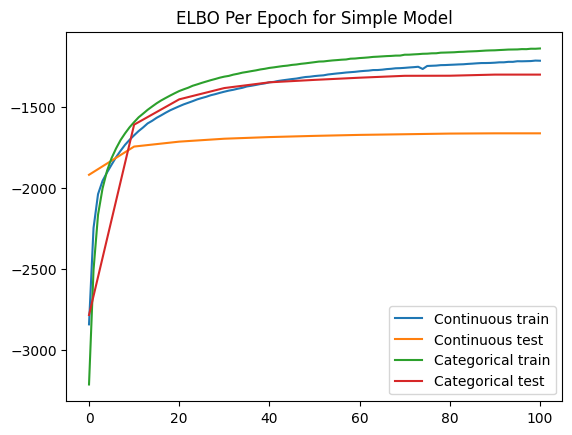

In [205]:
pd.DataFrame(
    {'Continuous train': train_losses, 'Continuous test': test_losses_pd,
     'Categorical train': train_losses_cat, 'Categorical test': test_losses_pd_cat}
).plot(title='ELBO Per Epoch for Simple Model')